In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('cafethai_prices.csv', parse_dates=['date'], date_format='%d/%m/%Y')
display(df.head())

,date,time,cash_type,coffee_name,money
0,2023-03-01,08:04:19,card,Latte,75
1,2023-03-01,08:08:54,cash,Americano with Milk,70
2,2023-03-01,08:09:03,card,Cappuccino,75
3,2023-03-01,08:10:26,cash,Cappuccino,75
4,2023-03-01,08:15:37,cash,Cappuccino,75


In [3]:
df.set_index('date', inplace=True)

df.head()

,time,cash_type,coffee_name,money
date,,,,
2023-03-01,08:04:19,card,Latte,75
2023-03-01,08:08:54,cash,Americano with Milk,70
2023-03-01,08:09:03,card,Cappuccino,75
2023-03-01,08:10:26,cash,Cappuccino,75
2023-03-01,08:15:37,cash,Cappuccino,75


In [4]:
#รวมข้อมูลยอดขายแต่ละเมนู ในแต่ละวัน
daily_sales = df.groupby(['date', 'coffee_name'])['money'].sum().reset_index()
daily_sales.head()

,date,coffee_name,money
0,2023-03-01,Americano,1235
1,2023-03-01,Americano with Milk,1890
2,2023-03-01,Cappuccino,1800
3,2023-03-01,Cocoa,350
4,2023-03-01,Cortado,980


In [5]:
# DataFrame for the count of each coffee item sold per day
daily_item_counts = df.groupby(['date', 'coffee_name']).size().reset_index(name='count')
daily_item_counts.head()

,date,coffee_name,count
0,2023-03-01,Americano,19
1,2023-03-01,Americano with Milk,27
2,2023-03-01,Cappuccino,24
3,2023-03-01,Cocoa,7
4,2023-03-01,Cortado,14


In [6]:
# DataFrame for the total sales per day for all coffee items
daily_total_sales = df.groupby('date')['money'].sum().reset_index(name='total_sales')
daily_total_sales.head()

,date,total_sales
0,2023-03-01,8645
1,2023-03-02,8560
2,2023-03-03,8690
3,2023-03-04,4365
4,2023-03-05,4565


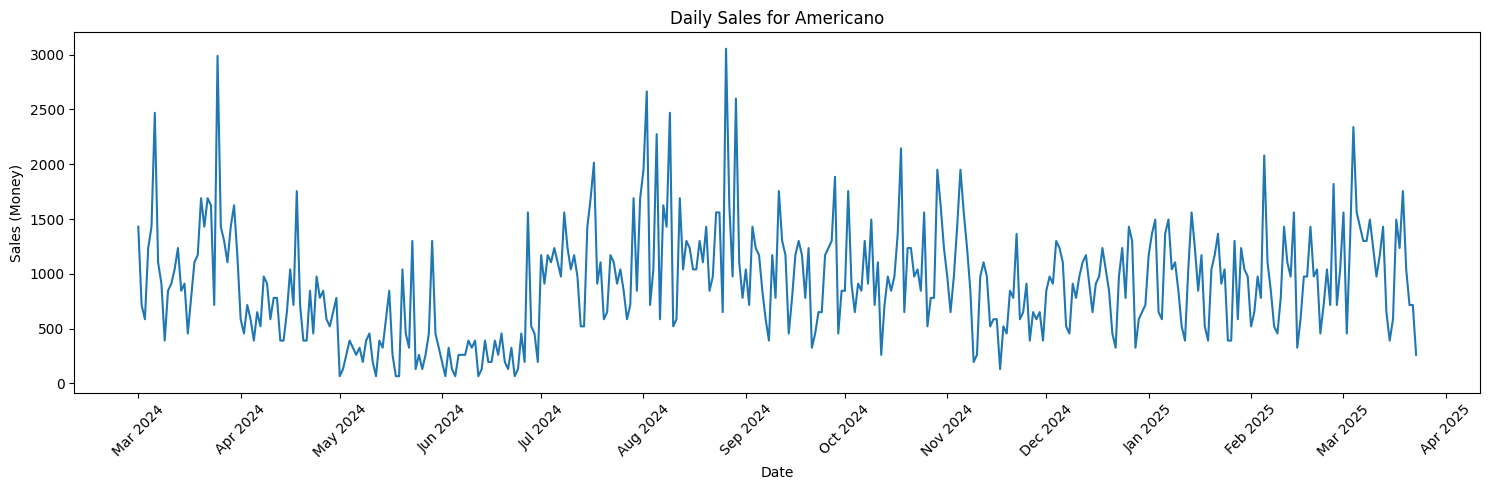

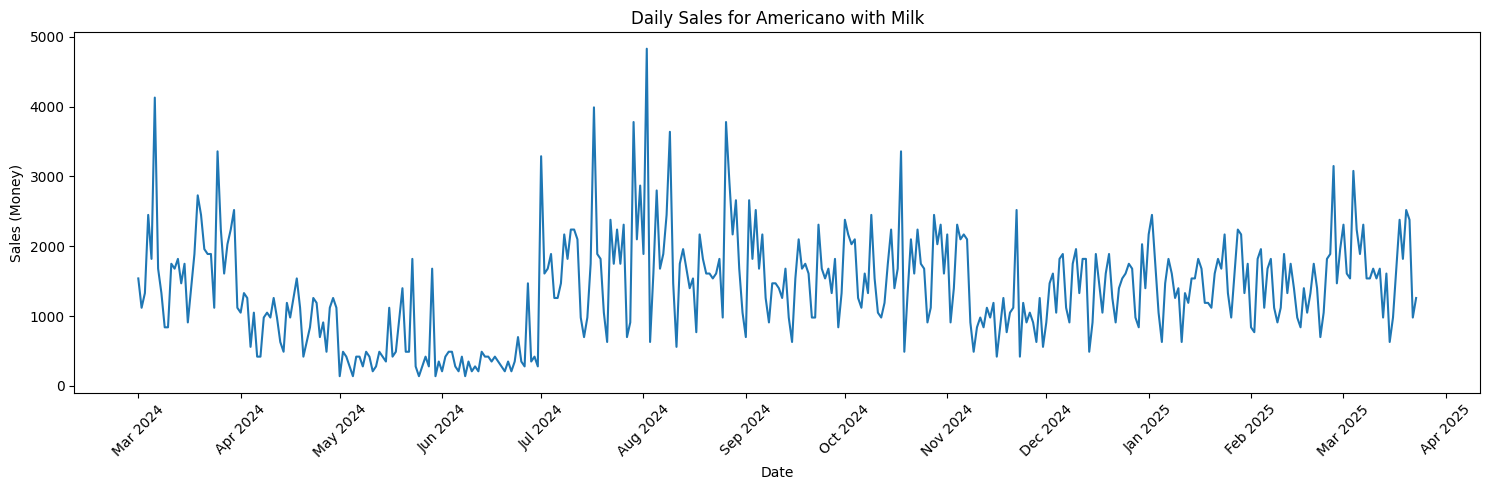

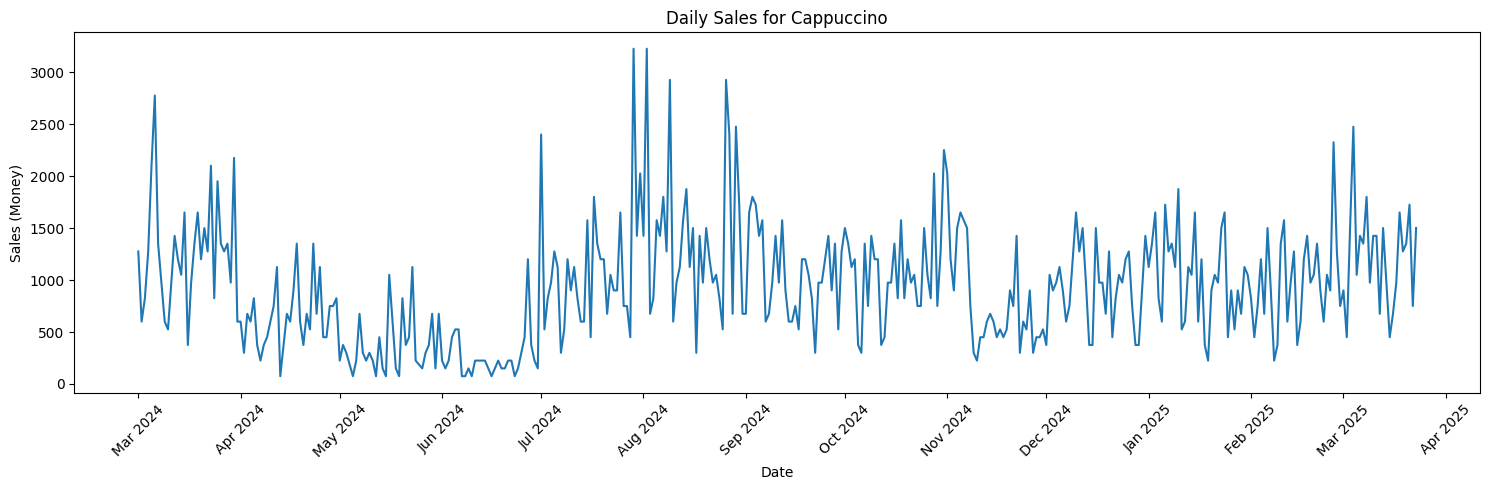

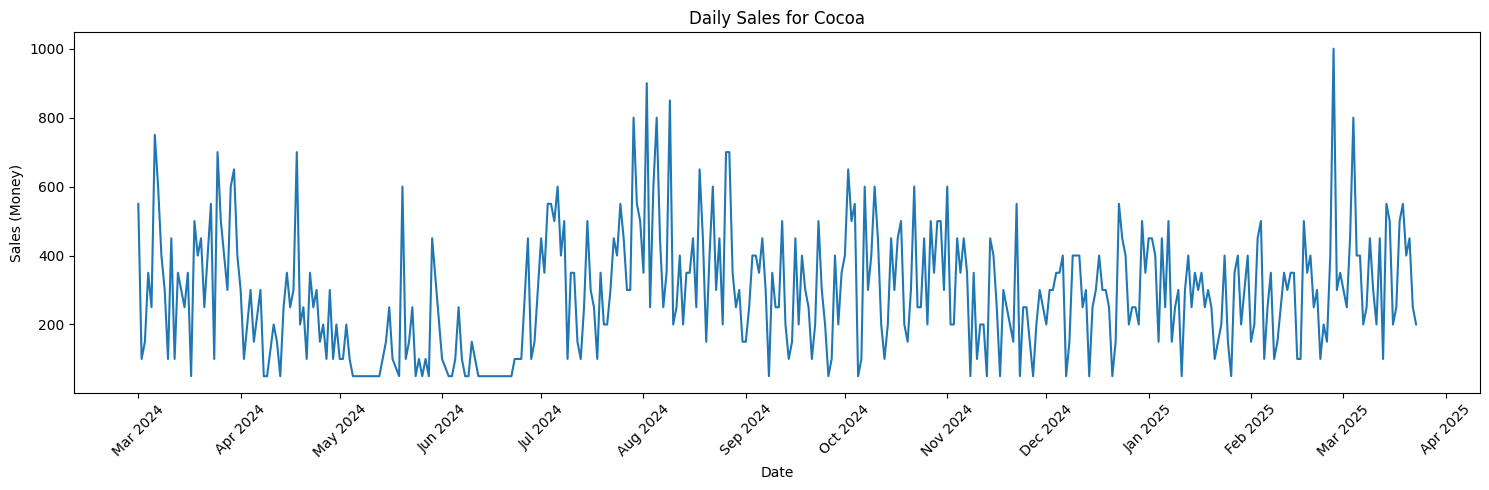

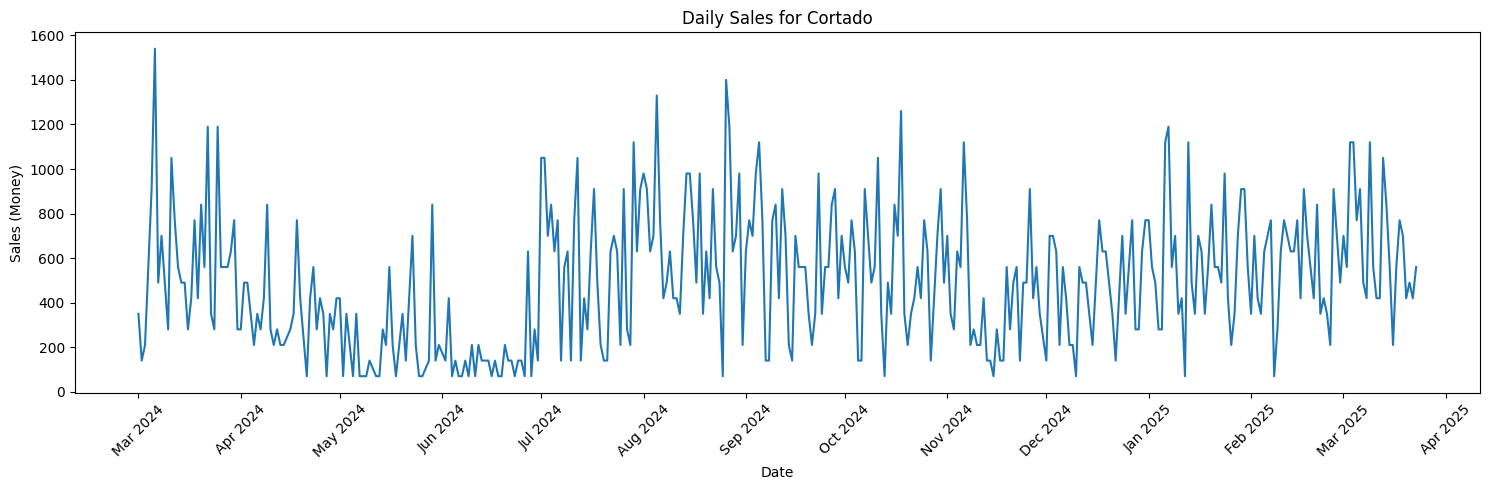

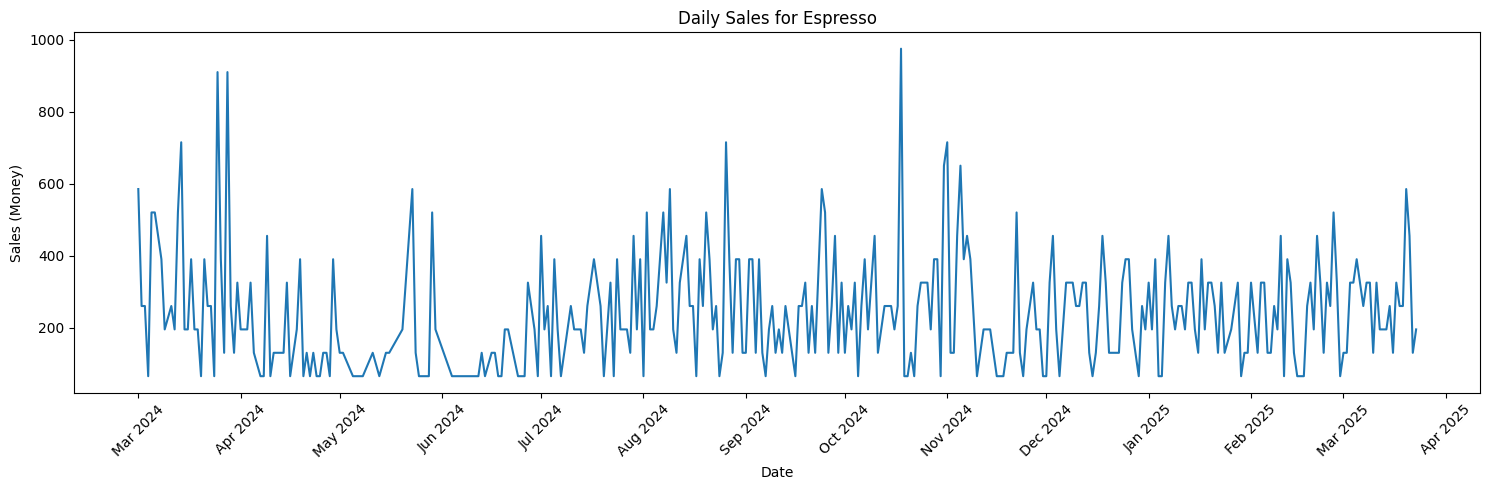

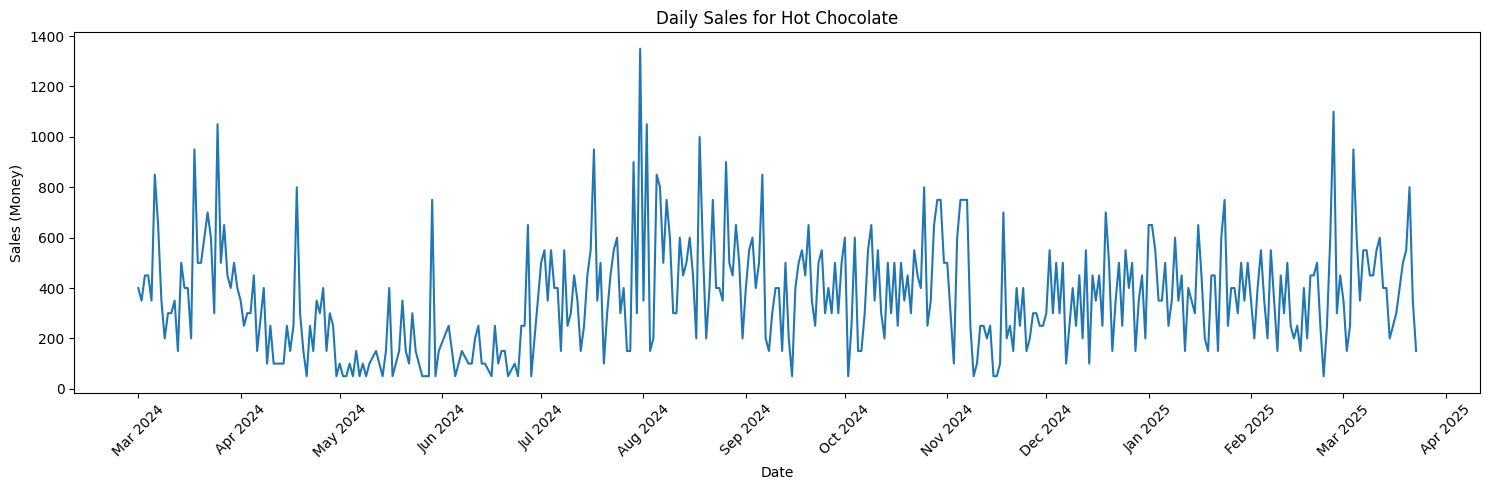

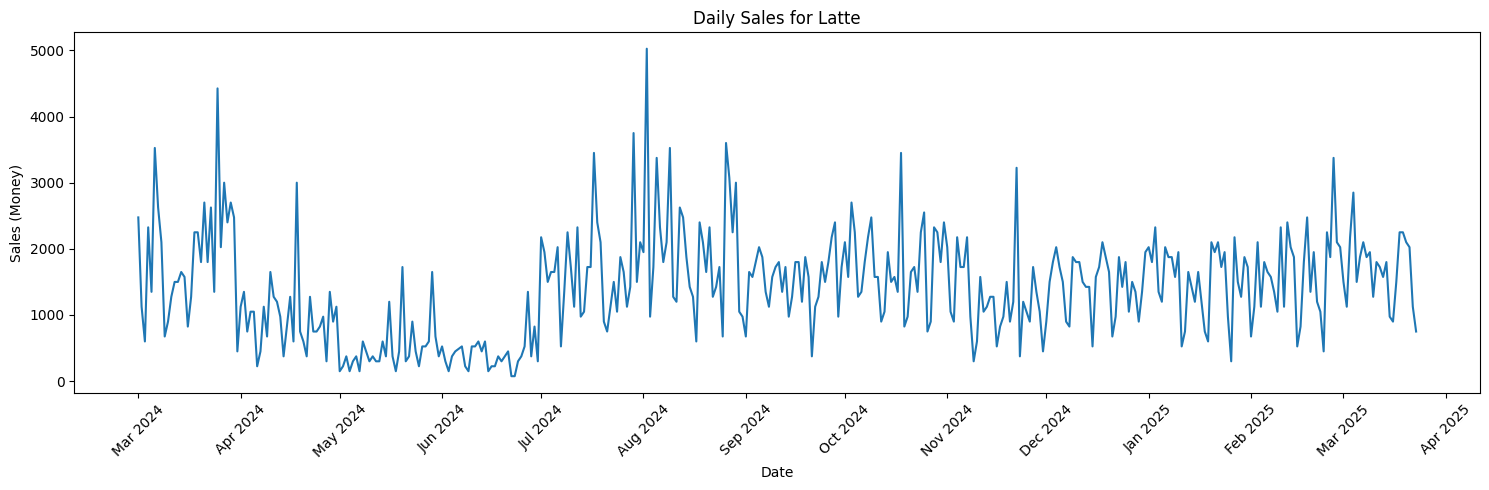

In [7]:
# Plot daily sales for each coffee item
for coffee_name in daily_sales['coffee_name'].unique():
    coffee_sales = daily_sales[daily_sales['coffee_name'] == coffee_name].copy() # Create a copy to avoid SettingWithCopyWarning
    # Ensure date is datetime, convert if needed with the correct format
    if not pd.api.types.is_datetime64_any_dtype(coffee_sales['date']):
         coffee_sales['date'] = pd.to_datetime(coffee_sales['date'], format='%d/%m/%Y', errors='coerce')

    coffee_sales.dropna(subset=['date'], inplace=True) # Remove rows with invalid dates

    # Filter data by date range
    # Update start and end dates if needed based on the correct format
    start_date = '2024-03-01' # Assuming the user wants to start from March 1, 2024
    end_date = '2025-03-23'
    coffee_sales = coffee_sales[(coffee_sales['date'] >= start_date) & (coffee_sales['date'] <= end_date)]

    coffee_sales.set_index('date', inplace=True) # Set date as index for easier plotting


    plt.figure(figsize=(15, 5))
    plt.plot(coffee_sales.index, coffee_sales['money'])
    plt.title(f'Daily Sales for {coffee_name}')
    plt.xlabel('Date')
    plt.ylabel('Sales (Money)')

    # Format x-axis to show month and year
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())


    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [9]:
def create_sales_features(df):
    # Ensure date is datetime and set as index
    # Check if date is already datetime, if not convert with the correct format
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

    df.set_index('date', inplace=True)

    # Create features from date
    df['dayofweek'] = df.index.dayofweek # 0 = Monday, 6 = Sunday
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['year'] = df.index.year # Add year feature

    # Sort by date before creating lag features
    df.sort_index(inplace=True)

    # Create Lag Features (previous sales)
    # We'll use data from 7 days and 14 days ago to help predict
    df['lag_7'] = df['total_sales'].shift(7)
    df['lag_14'] = df['total_sales'].shift(14)

    # Create Rolling Mean
    df['rolling_mean_7'] = df['total_sales'].shift(1).rolling(window=7).mean()

    # Reset index to make date a column again
    df.reset_index(inplace=True)

    return df


daily_total_sales_features = create_sales_features(daily_total_sales.copy())


# Drop rows with NaN values created by lag features
daily_total_sales_features.dropna(inplace=True)

display(daily_total_sales_features.head())

,date,total_sales,dayofweek,quarter,month,dayofyear,year,lag_7,lag_14,rolling_mean_7
14,2023-03-15,7200,2,1,3,74,2023,7290.0,8645.0,6460.000000
15,2023-03-16,7315,3,1,3,75,2023,7140.0,8560.0,6447.142857
16,2023-03-17,7510,4,1,3,76,2023,7120.0,8690.0,6472.142857
17,2023-03-18,5250,5,1,3,77,2023,5735.0,4365.0,6527.857143
18,2023-03-19,4765,6,1,3,78,2023,3635.0,4565.0,6458.571429


In [10]:
# Convert 'date' column to datetime objects
# Ensure 'date' is a column first if it was set as index
if df.index.name == 'date':
    df.reset_index(inplace=True)

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

# Display the data types to confirm the conversion
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68359 entries, 0 to 68358
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         68359 non-null  datetime64[ns]
 1   time         68359 non-null  object        
 2   cash_type    68359 non-null  object        
 3   coffee_name  68359 non-null  object        
 4   money        68359 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.6+ MB


None

In [11]:
FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'lag_7', 'lag_14', 'rolling_mean_7']
TARGET = 'total_sales'

In [12]:
X = daily_total_sales_features[FEATURES]
y = daily_total_sales_features[TARGET]

In [13]:
# Determine the split date
split_date = '2025-03-01'

# Ensure the 'date' column is in datetime format for comparison
daily_total_sales_features['date'] = pd.to_datetime(daily_total_sales_features['date'])

# Split data into training and testing sets based on date
train_data = daily_total_sales_features[daily_total_sales_features['date'] < split_date]
test_data = daily_total_sales_features[daily_total_sales_features['date'] >= split_date]

X_train = train_data[FEATURES]
y_train = train_data[TARGET]
X_test = test_data[FEATURES]
y_test = test_data[TARGET]


print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (717, 7)
Shape of y_train: (717,)
Shape of X_test: (61, 7)
Shape of y_test: (61,)


In [14]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [15]:
# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100,
                             learning_rate=0.05, # ค่อยๆ เรียนรู้ช้าๆ
                             early_stopping_rounds=10, # ถ้าผลไม่ดีขึ้น 10 รอบให้หยุด
                             random_state=42)

In [16]:
# XGBoost ต้องมี evaluation set เพื่อใช้ early stopping
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [17]:
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

In [19]:
rf_mae = mean_absolute_error(y_test, rf_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

In [20]:
print(f"\nความคลาดเคลื่อนเฉลี่ยของ Random Forest: {rf_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ความคลาดเคลื่อนเฉลี่ยของ XGBoost: {xgb_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ยอดขายรวมใน Test Set: {y_test.sum():.2f} บาท")


ความคลาดเคลื่อนเฉลี่ยของ Random Forest: 1128.13 จากทั้งหมด 61 จุดข้อมูล
ความคลาดเคลื่อนเฉลี่ยของ XGBoost: 1035.21 จากทั้งหมด 61 จุดข้อมูล
ยอดขายรวมใน Test Set: 366330.00 บาท


In [21]:
results = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred
})

# Set the index of the results DataFrame to the dates from the test set
results.index = test_data['date']

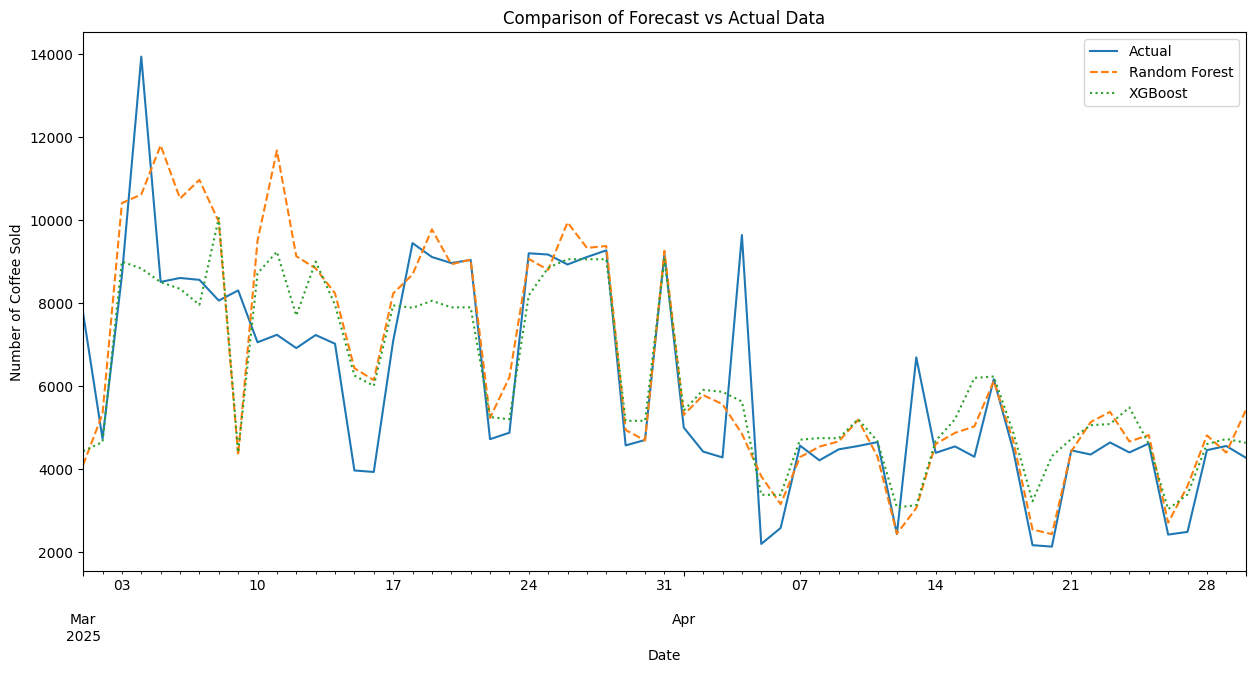

In [22]:
results.plot(figsize=(15, 7), style=['-', '--', ':'],
             title='Comparison of Forecast vs Actual Data')
plt.ylabel('Number of Coffee Sold')
plt.xlabel('Date')
plt.legend()
plt.show()

In [23]:
def plot_feature_importance(model, features, model_name):
    # สร้าง DataFrame ของ feature importance
    fi = pd.DataFrame(data=model.feature_importances_,
                      index=features,
                      columns=['importance'])
    fi_sorted = fi.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=fi_sorted.index, y=fi_sorted['importance'])
    plt.title(f'Feature Importance of the {model_name} Model') # Changed title to English
    plt.xticks(rotation=45)
    plt.xlabel('Features') # Added x-axis label
    plt.show()

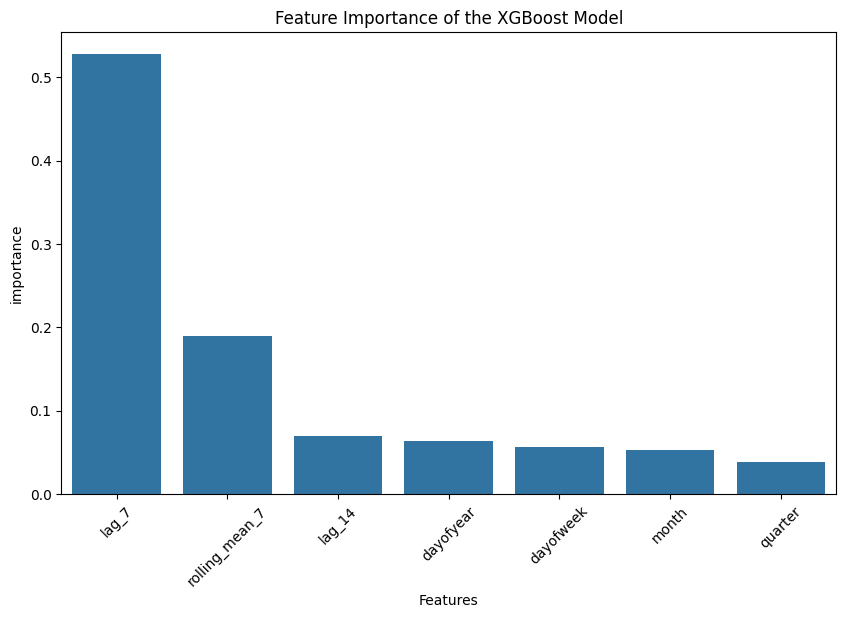

In [24]:
plot_feature_importance(xgb_model, FEATURES, 'XGBoost')

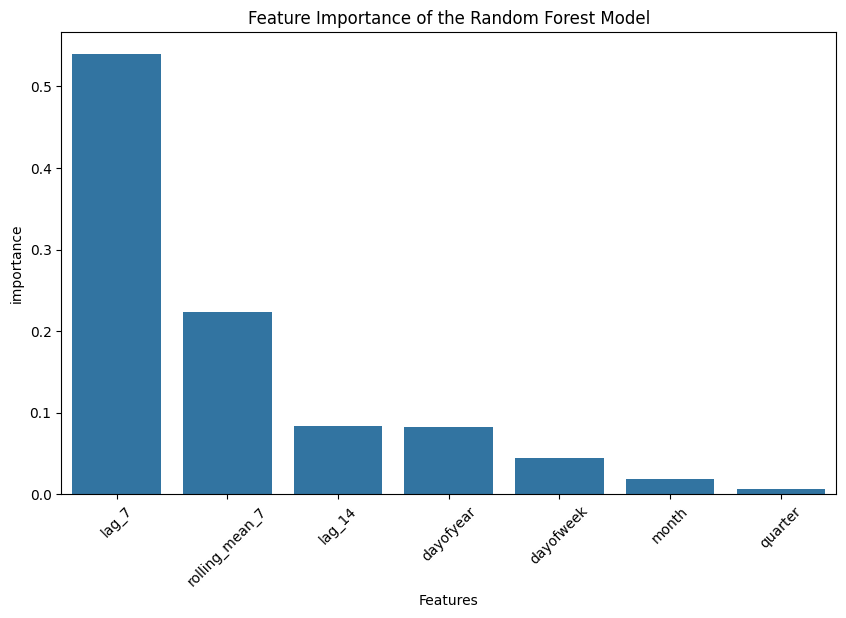

In [25]:
plot_feature_importance(rf_model, FEATURES, 'Random Forest')

In [26]:
!pip install prophet

In [27]:
from prophet import Prophet

In [28]:
# Prepare data for Prophet: requires 'ds' (datetime) and 'y' (target) columns
# Use the already split train_data and test_data DataFrames

# Add print statements to check columns
print("Columns in train_data:", train_data.columns)
print("Columns in test_data:", test_data.columns)

Columns in train_data: Index(['date', 'total_sales', 'dayofweek', 'quarter', 'month', 'dayofyear',
       'year', 'lag_7', 'lag_14', 'rolling_mean_7'],
      dtype='object')
Columns in test_data: Index(['date', 'total_sales', 'dayofweek', 'quarter', 'month', 'dayofyear',
       'year', 'lag_7', 'lag_14', 'rolling_mean_7'],
      dtype='object')


In [29]:
prophet_train = train_data[['date', 'total_sales']].rename(columns={'date': 'ds', 'total_sales': 'y'})
prophet_test = test_data[['date', 'total_sales']].rename(columns={'date': 'ds', 'total_sales': 'y'})

# Prophet requires a continuous time series without missing dates.
# It's generally recommended to ensure the data has a daily frequency and fill missing dates if necessary.
# For simplicity now, we'll use the data as is, but note this for potential issues.
# If there are missing dates, Prophet can handle them to some extent but performance might be affected.

In [30]:
# Initialize and fit the Prophet model
model = Prophet(weekly_seasonality=True,yearly_seasonality=True)
model.fit(prophet_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm6ublyyh/k2fltgnf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm6ublyyh/q6q3bnpe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19612', 'data', 'file=/tmp/tmpm6ublyyh/k2fltgnf.json', 'init=/tmp/tmpm6ublyyh/q6q3bnpe.json', 'output', 'file=/tmp/tmpm6ublyyh/prophet_modeluloz8x6y/prophet_model-20250921154956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:49:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:49:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [31]:
# Display the index (dates) of the RF/XGBoost test set
display(y_test.index)

Index([731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744,
       745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758,
       759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772,
       773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786,
       787, 788, 789, 790, 791],
      dtype='int64')

In [32]:
# Create a future dataframe for predictions
# We need to predict for the dates in the test set
future = model.make_future_dataframe(periods=len(prophet_test))

In [33]:
# Make predictions
forecast = model.predict(future)

In [34]:
# Display the forecast
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

,ds,yhat,yhat_lower,yhat_upper
0,2023-03-15,9233.730622,6913.251441,11679.877418
1,2023-03-16,9251.532056,6930.509911,11619.346946
2,2023-03-17,8906.581304,6306.955109,11108.485274
3,2023-03-18,5968.444038,3607.129901,8354.372167
4,2023-03-19,6036.730926,3648.819599,8306.222240


In [35]:
# Evaluate the Prophet model
# Merge actual values with forecast
prophet_results = forecast.set_index('ds')[['yhat']].join(prophet_test.set_index('ds')[['y']])
prophet_results.dropna(inplace=True) # Drop rows where there are no actual values (if future was longer than test)

In [36]:
# Calculate MAE
prophet_mae = mean_absolute_error(prophet_results['y'], prophet_results['yhat'])

print(f"ความคลาดเคลื่อนเฉลี่ยของ Prophet: {prophet_mae:.2f} จากทั้งหมด {len(prophet_results)} จุดข้อมูล")
print(f"ยอดขายรวมใน Test Set (สำหรับ Prophet): {prophet_results['y'].sum():.2f} บาท")

ความคลาดเคลื่อนเฉลี่ยของ Prophet: 1180.71 จากทั้งหมด 61 จุดข้อมูล
ยอดขายรวมใน Test Set (สำหรับ Prophet): 366330.00 บาท


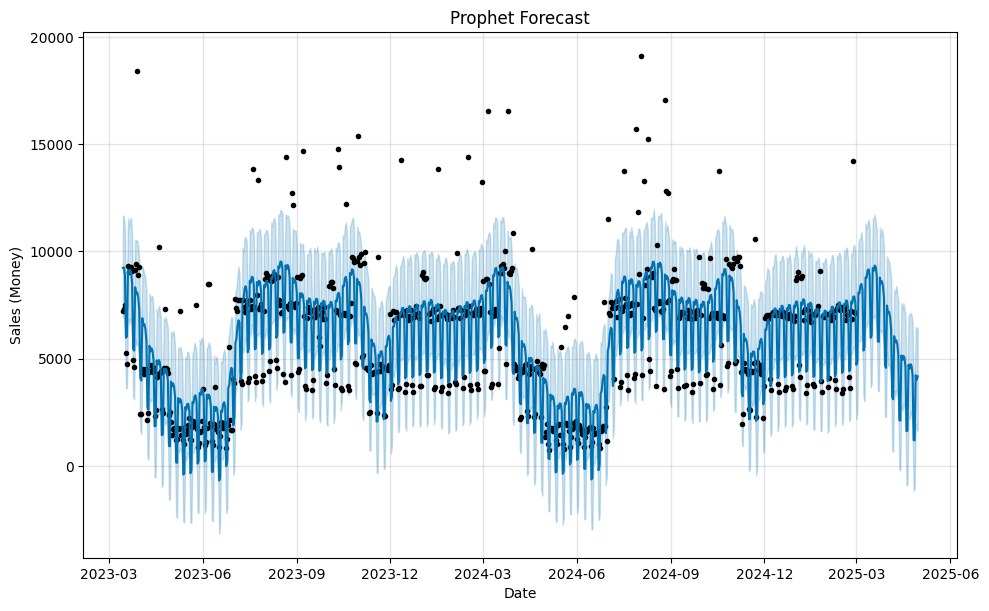

In [37]:
# Plot the forecast
fig1 = model.plot(forecast)
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales (Money)')
plt.show()

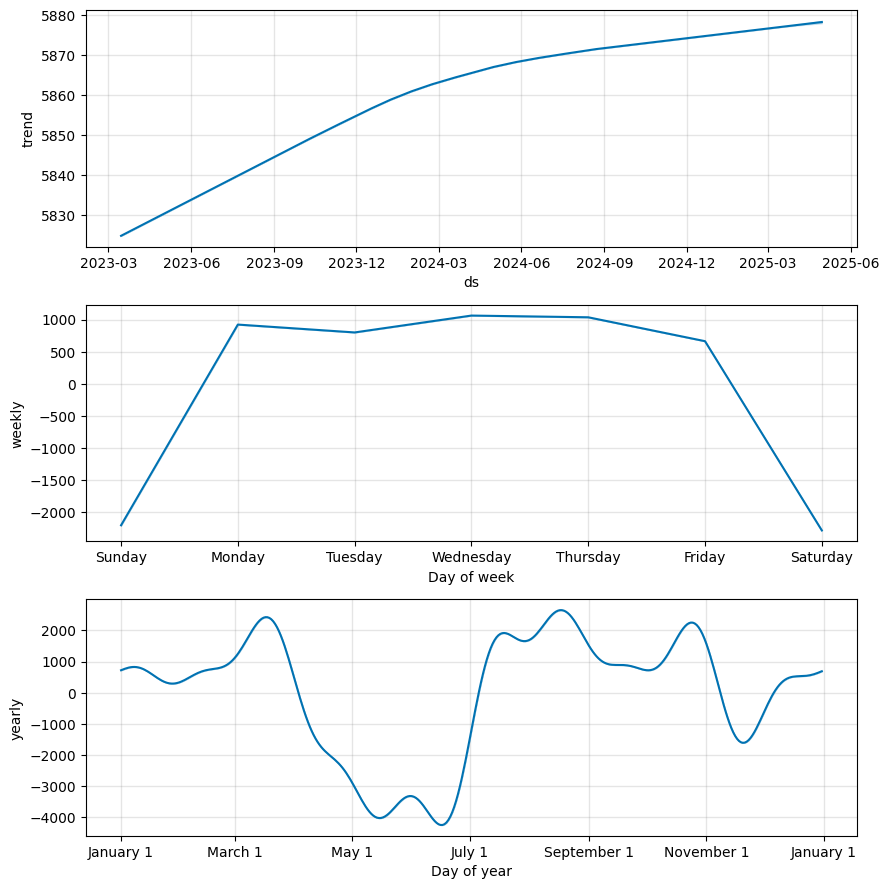

In [38]:
# Plot the components of the forecast
fig2 = model.plot_components(forecast)
plt.show()

In [39]:
pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-lg5wm3br
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-lg5wm3br
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit fcd09fe8b6bf57643bde7847bf42a6719b7ee205
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for chronos-forecasting: filename=chronos_forecasting-1.5.3-py3-none-any.whl size=29457 sha256=1ed17963a7cb042bbb2bbd927e0f5c26133b09dc77300086832dedd8cf911cd2
  Stored in directory: /tmp/pip-ephem-wheel-cache-8l5umfzl/wheels/b9/a6/b5/75fca7306751a3bc92a63680f861f44a42a8776f6423cf0188
Successfully built chronos-forecasting


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

In [41]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-small",
  device_map="cuda",
  dtype=torch.bfloat16,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [48]:
# Prepare the data for Chronos
# Chronos expects a torch tensor as input. We'll use the 'total_sales' column
# Filter data before the split date
split_date = pd.to_datetime('2025-03-01')
historical_sales_before_split = daily_total_sales[daily_total_sales['date'] < split_date].copy()


# Convert the 'total_sales' column from the filtered data to a torch tensor
context = torch.tensor(historical_sales_before_split['total_sales'].values)

# Define the prediction length (e.g., 60 days for one month forecast)
prediction_length = 60

# Make a forecast using the Chronos pipeline
forecast = pipeline.predict(context, prediction_length)

# The forecast is a distribution. We can get the median prediction.
# The forecast tensor will have shape (num_samples, prediction_length)
# We take the median along the sample dimension (dim=0)
median_prediction = forecast[0].median(dim=0).values

# Display the median prediction
print(f"Chronos Median Forecast for the next {prediction_length} days:")
display(median_prediction)

Chronos Median Forecast for the next 60 days:


tensor([3855.2769, 3766.6499, 6912.9102, 7001.5371, 7001.5371, 7090.1641,
        7001.5371, 3589.3960, 3722.3364, 7090.1641, 7090.1641, 7001.5371,
        7045.8506, 7090.1641, 3766.6499, 3678.0229, 7090.1641, 7134.4785,
        6957.2236, 7045.8506, 7134.4785, 3722.3364, 3810.9634, 6957.2236,
        7001.5371, 7045.8506, 7090.1641, 6868.5967, 3633.7095, 3722.3364,
        7001.5371, 6912.9102, 6868.5967, 7001.5371, 6868.5967, 3678.0229,
        3722.3364, 7001.5371, 7134.4785, 7001.5371, 7045.8506, 6912.9102,
        3766.6499, 3722.3364, 7001.5371, 7001.5371, 6957.2236, 7001.5371,
        6868.5967, 3722.3364, 3810.9634, 6691.3428, 6691.3428, 6779.9697,
        6868.5967, 4874.4883, 3456.4551, 3589.3960, 6248.2070, 6514.0889])

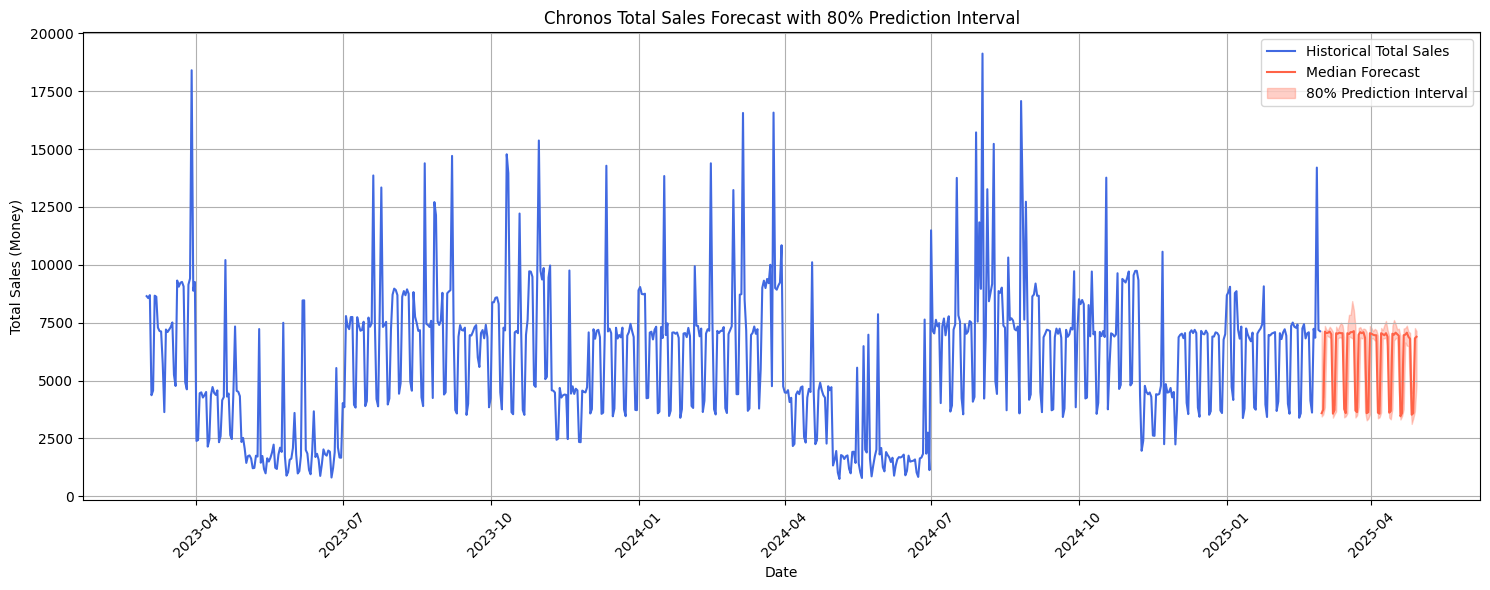

In [43]:
# Visualize the Chronos forecast with prediction interval
plt.figure(figsize=(15, 6))

# Plot historical data (daily_total_sales before split_date)
plt.plot(historical_sales_before_split['date'], historical_sales_before_split['total_sales'], color="royalblue", label="Historical Total Sales")

# Create dates for the forecast period
# The forecast starts immediately after the last date in the historical_sales_before_split
last_date_historical = historical_sales_before_split['date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date_historical + pd.Timedelta(days=1), periods=prediction_length, freq='D')

# Calculate quantiles for the prediction interval
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

# Plot the median forecast
plt.plot(forecast_dates, median, color="tomato", label="Median Forecast")

# Plot the 80% prediction interval
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")


plt.title('Chronos Total Sales Forecast with 80% Prediction Interval')
plt.xlabel('Date')
plt.ylabel('Total Sales (Money)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
forecast[0][:][0]

tensor([3589.3960, 3855.2769, 7090.1641, 7134.4785, 7488.9863, 7311.7324,
        7134.4785, 3633.7095, 3545.0825, 7311.7324, 7090.1641, 9217.2139,
        9128.5869, 9172.9004, 3943.9043, 3545.0825, 7311.7324, 7178.7920,
        7267.4189, 7533.2998, 7488.9863, 3678.0229, 3855.2769, 7223.1055,
        7223.1055, 7178.7920, 7223.1055, 7090.1641, 3810.9634, 3855.2769,
        7356.0459, 7488.9863, 7134.4785, 7223.1055, 7223.1055, 3633.7095,
        3678.0229, 7267.4189, 7444.6729, 7400.3594, 7001.5371, 7178.7920,
        3722.3364, 3633.7095, 7134.4785, 7444.6729, 7134.4785, 7001.5371,
        7223.1055, 3545.0825, 3678.0229, 7045.8506, 7267.4189, 7178.7920,
        6912.9102, 7045.8506, 3500.7686, 3678.0229, 7267.4189, 7134.4785])

In [45]:
median_forecast = np.median(forecast[0], axis=0)

print("ค่ามัธยฐานของผลการพยากรณ์ 12 เดือนข้างหน้า")
print(median_forecast)

ค่ามัธยฐานของผลการพยากรณ์ 12 เดือนข้างหน้า
[3589.396  3744.4932 7112.3213 7045.8506 7068.0073 7112.3213 7001.537
 3567.2393 3722.3364 7045.8506 7023.694  7068.0073 7045.8506 7045.8506
 3766.65   3589.396  7045.8506 7001.537  7090.164  7090.1646 7134.4785
 3700.1797 3633.7095 6979.3804 7090.164  7045.8506 7090.164  6846.44
 3589.396  3633.7095 7045.8506 7023.694  6979.3804 6957.2236 6957.2236
 3611.5527 3567.2393 7045.8506 7001.537  6957.2236 7045.8506 6890.7534
 3611.5527 3678.023  7023.694  6979.3804 7068.0073 7001.537  6935.067
 3456.455  3589.396  6957.2236 6979.3804 7068.0073 6890.7534 6802.1265
 3522.9255 3589.396  6824.283  6890.7534]


Predictionแต่ละชนิดขายได้กี่แก้ว

In [50]:
#อ่านข้อมูลcafethai_prices.csv แล้วแสดงส่วนหัวมา
df = pd.read_csv("cafethai_prices.csv")
df.head()

,date,time,cash_type,coffee_name,money
0,1/3/2023,08:04:19,card,Latte,75
1,1/3/2023,08:08:54,cash,Americano with Milk,70
2,1/3/2023,08:09:03,card,Cappuccino,75
3,1/3/2023,08:10:26,cash,Cappuccino,75
4,1/3/2023,08:15:37,cash,Cappuccino,75


In [51]:
#ทำแยกตามชนิดกาแฟ

#รวม date+time
df['datetime'] = pd.to_datetime(df['date'].astype(str) + " " + df['time'].astype(str), dayfirst=True)

#สร้างcolumn date เฉพาะวัน(ตัดเวลาออก)
df['date'] = df['datetime'].dt.date

#นับจำนวนแก้วที่ขายต่อวันต่อ coffee_name
daily_sales = df.groupby(['date','coffee_name']).size().reset_index(name='cups_sold')

#แสดง10อันแรก
print(daily_sales.head(10))

         date          coffee_name  cups_sold
0  2023-03-01            Americano         19
1  2023-03-01  Americano with Milk         27
2  2023-03-01           Cappuccino         24
3  2023-03-01                Cocoa          7
4  2023-03-01              Cortado         14
5  2023-03-01             Espresso          6
6  2023-03-01        Hot Chocolate          4
7  2023-03-01                Latte         24
8  2023-03-02            Americano         19
9  2023-03-02  Americano with Milk         26


DEBUG:cmdstanpy:input tempfile: /tmp/tmpm6ublyyh/jfq2yq7j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm6ublyyh/legxw_eh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68208', 'data', 'file=/tmp/tmpm6ublyyh/jfq2yq7j.json', 'init=/tmp/tmpm6ublyyh/legxw_eh.json', 'output', 'file=/tmp/tmpm6ublyyh/prophet_modelniutjw9o/prophet_model-20250921162824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:28:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:28:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


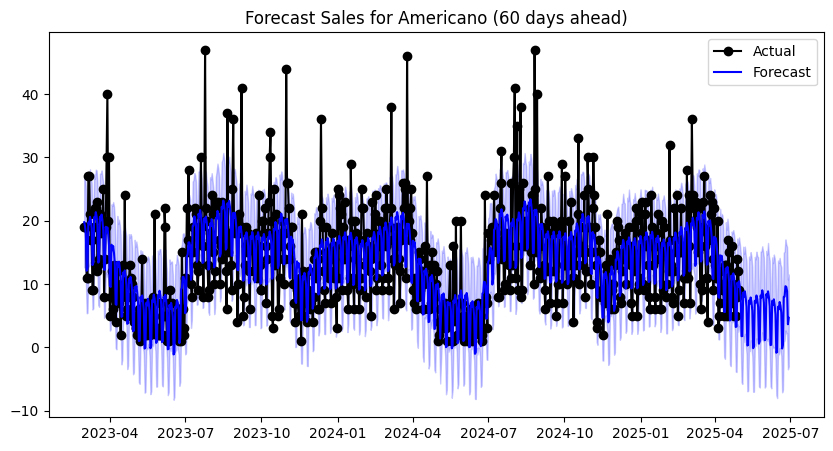

DEBUG:cmdstanpy:input tempfile: /tmp/tmpm6ublyyh/0_tf_2r7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm6ublyyh/h0zcrmfy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87184', 'data', 'file=/tmp/tmpm6ublyyh/0_tf_2r7.json', 'init=/tmp/tmpm6ublyyh/h0zcrmfy.json', 'output', 'file=/tmp/tmpm6ublyyh/prophet_modelazj3hnv8/prophet_model-20250921162824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:28:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:28:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


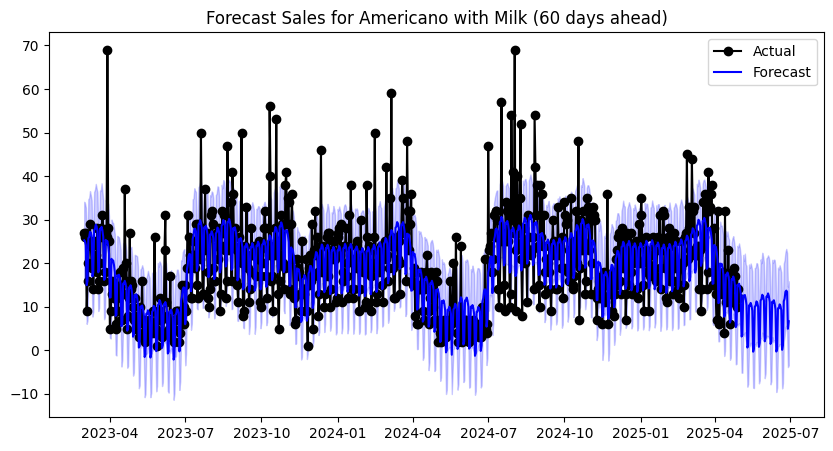

DEBUG:cmdstanpy:input tempfile: /tmp/tmpm6ublyyh/6ucu0dij.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm6ublyyh/3lxkt8r0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11004', 'data', 'file=/tmp/tmpm6ublyyh/6ucu0dij.json', 'init=/tmp/tmpm6ublyyh/3lxkt8r0.json', 'output', 'file=/tmp/tmpm6ublyyh/prophet_modelbhimbcy1/prophet_model-20250921162825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:28:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:28:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


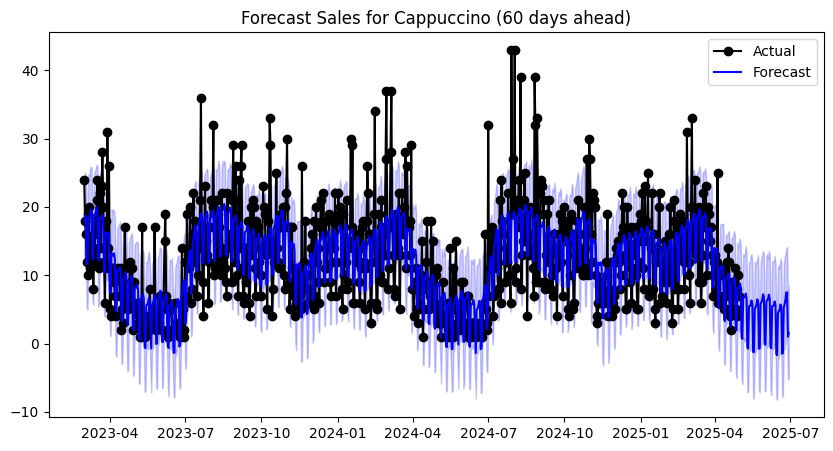

DEBUG:cmdstanpy:input tempfile: /tmp/tmpm6ublyyh/2fhv6ydi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm6ublyyh/o8j6l1xp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97615', 'data', 'file=/tmp/tmpm6ublyyh/2fhv6ydi.json', 'init=/tmp/tmpm6ublyyh/o8j6l1xp.json', 'output', 'file=/tmp/tmpm6ublyyh/prophet_model3gi9on19/prophet_model-20250921162826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:28:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:28:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


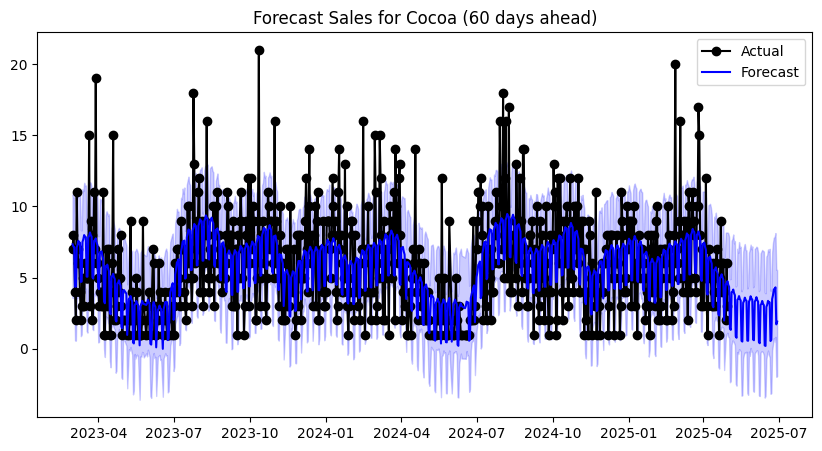

DEBUG:cmdstanpy:input tempfile: /tmp/tmpm6ublyyh/1fox2j1j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm6ublyyh/34yqg01p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3097', 'data', 'file=/tmp/tmpm6ublyyh/1fox2j1j.json', 'init=/tmp/tmpm6ublyyh/34yqg01p.json', 'output', 'file=/tmp/tmpm6ublyyh/prophet_modelaldl7ot6/prophet_model-20250921162826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:28:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:28:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


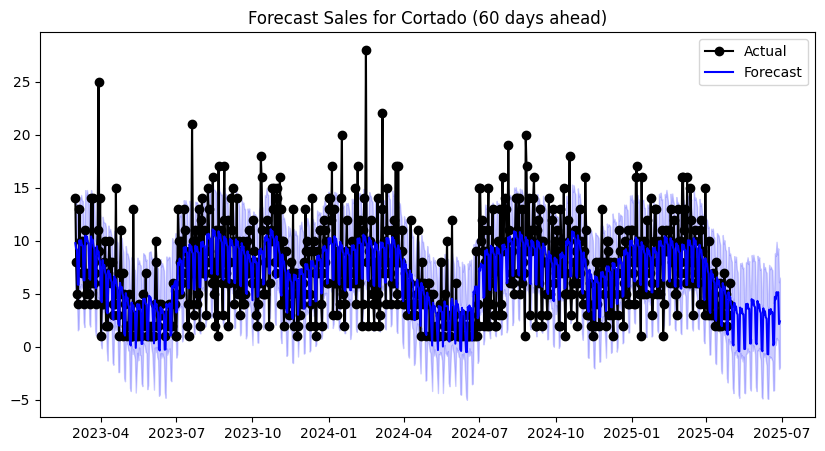

DEBUG:cmdstanpy:input tempfile: /tmp/tmpm6ublyyh/5o348xim.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm6ublyyh/vh336_lg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83583', 'data', 'file=/tmp/tmpm6ublyyh/5o348xim.json', 'init=/tmp/tmpm6ublyyh/vh336_lg.json', 'output', 'file=/tmp/tmpm6ublyyh/prophet_modelq0zmoeyd/prophet_model-20250921162827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:28:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:28:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


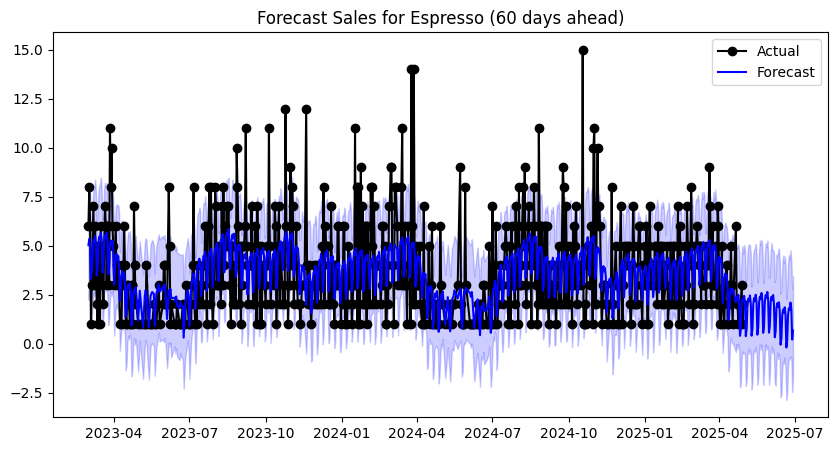

DEBUG:cmdstanpy:input tempfile: /tmp/tmpm6ublyyh/iu23urhv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm6ublyyh/xii7pb_x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87709', 'data', 'file=/tmp/tmpm6ublyyh/iu23urhv.json', 'init=/tmp/tmpm6ublyyh/xii7pb_x.json', 'output', 'file=/tmp/tmpm6ublyyh/prophet_modelagxtekla/prophet_model-20250921162828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:28:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:28:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


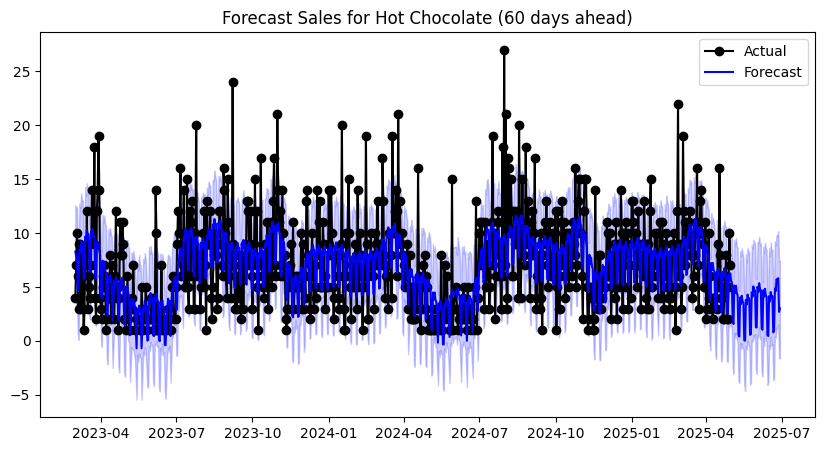

DEBUG:cmdstanpy:input tempfile: /tmp/tmpm6ublyyh/85uev284.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm6ublyyh/l49h20ec.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21538', 'data', 'file=/tmp/tmpm6ublyyh/85uev284.json', 'init=/tmp/tmpm6ublyyh/l49h20ec.json', 'output', 'file=/tmp/tmpm6ublyyh/prophet_modelymc9uiki/prophet_model-20250921162829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:28:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:28:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


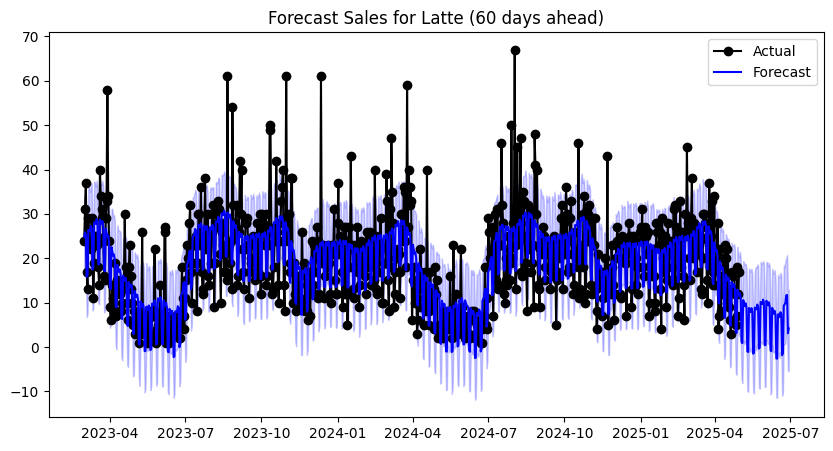

In [52]:
predictions = {}

for coffee in daily_sales['coffee_name'].unique():
    #เลือกเฉพาะกาแฟชนิดนั้น
    ts = daily_sales[daily_sales['coffee_name'] == coffee][['date','cups_sold']]

    # Prophet(ทำนายล่วงหน้า) ต้องการcolumn ds = วันที่, y = ค่าที่จะทำนาย
    ts = ts.rename(columns={'date':'ds','cups_sold':'y'})

    #สร้างและtrain model
    model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    model.fit(ts)

    #ทำนาย 60 วันข้างหน้า
    future = model.make_future_dataframe(periods=60)

    #พยากรณ์
    forecast = model.predict(future)

    #เก็บผลลัพธ์ไว้
    predictions[coffee] = forecast

    #เก็บผลลัพธ์ไว้
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(ts['ds'], ts['y'], 'ko-', label='Actual')
    ax.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast')
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2)
    ax.set_title(f"Forecast Sales for {coffee} (60 days ahead)")
    ax.legend()

    #แสดงกราฟผลลัพธ์
    plt.show()


In [53]:
all_forecasts = []

for coffee, fc in predictions.items():
    #cutoff=วันล่าสุดในข้อมูลจริง
    cutoff = daily_sales['date'].max()

    #เลือกเฉพาะวันที่ > cutoff(60 วันในอนาคต)
    sub = fc[fc['ds'] > pd.to_datetime(cutoff)][['ds','yhat','yhat_lower','yhat_upper']].copy()
    sub['coffee_name'] = coffee
    all_forecasts.append(sub)

#การรวมDataFrame หลายๆตัวเข้าด้วยกันเป็นอันเดียว
forecast_60days = pd.concat(all_forecasts)

print(forecast_60days.head(20))


            ds      yhat  yhat_lower  yhat_upper coffee_name
790 2025-05-01  9.506918    2.990992   16.284716   Americano
791 2025-05-02  7.936232    0.945475   14.908938   Americano
792 2025-05-03  1.759430   -5.532723    8.839684   Americano
793 2025-05-04  1.788706   -5.768703    8.772506   Americano
794 2025-05-05  8.662543    1.800682   15.904010   Americano
795 2025-05-06  7.997170    0.835452   14.757440   Americano
796 2025-05-07  8.854686    2.133678   15.921210   Americano
797 2025-05-08  7.932463    0.539858   14.599646   Americano
798 2025-05-09  6.401866   -0.993895   13.621333   Americano
799 2025-05-10  0.289961   -6.945681    7.113769   Americano
800 2025-05-11  0.408913   -6.854004    7.582526   Americano
801 2025-05-12  7.396318    0.416175   14.352262   Americano
802 2025-05-13  6.866670   -0.586766   13.861567   Americano
803 2025-05-14  7.879522    1.133308   15.044060   Americano
804 2025-05-15  7.128958   -0.031504   14.292203   Americano
805 2025-05-16  5.782391